In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

# برای نمایش بهتر جدول‌ها
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)


In [2]:
data = fetch_california_housing(as_frame=True)

df = data.frame.copy()  # شامل ویژگی‌ها + هدف
feature_names = data.feature_names
target_name = "MedHouseVal"

print("Shape:", df.shape)
print("Features:", feature_names)
print("Target:", target_name)
print("\nHead:\n", df.head())

# جدا کردن X و y
X = df[feature_names]
y = df[target_name]


Shape: (20640, 9)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: MedHouseVal

Head:
    MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  Longitude  MedHouseVal
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88    -122.23        4.526
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86    -122.22        3.585
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85    -122.24        3.521
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85    -122.25        3.413
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85    -122.25        3.422


In [3]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # فقط روی train fit
X_test_scaled  = scaler.transform(X_test)        # فقط transform روی test

# برای اینکه نام ستون‌ها حفظ شود (تحلیل ضرایب راحت‌تر)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
X_test_scaled_df  = pd.DataFrame(X_test_scaled,  columns=feature_names, index=X_test.index)

print("\nScaled train mean (approx):\n", X_train_scaled_df.mean().round(3))
print("\nScaled train std (approx):\n", X_train_scaled_df.std(ddof=0).round(3))


Train size: (16512, 8) Test size: (4128, 8)

Scaled train mean (approx):
 MedInc       -0.0
HouseAge     -0.0
AveRooms     -0.0
AveBedrms    -0.0
Population   -0.0
AveOccup      0.0
Latitude      0.0
Longitude     0.0
dtype: float64

Scaled train std (approx):
 MedInc        1.0
HouseAge      1.0
AveRooms      1.0
AveBedrms     1.0
Population    1.0
AveOccup      1.0
Latitude      1.0
Longitude     1.0
dtype: float64


In [4]:
lr = LinearRegression()
lr.fit(X_train_scaled_df, y_train)

# پیش‌بینی
y_train_pred_lr = lr.predict(X_train_scaled_df)
y_test_pred_lr  = lr.predict(X_test_scaled_df)

# R2
r2_train_lr = r2_score(y_train, y_train_pred_lr)
r2_test_lr  = r2_score(y_test,  y_test_pred_lr)
gap_lr = r2_train_lr - r2_test_lr

print("=== Linear Regression ===")
print(f"Train R2: {r2_train_lr:.4f}")
print(f"Test  R2: {r2_test_lr:.4f}")
print(f"Gap (Train - Test): {gap_lr:.4f}")

# ضرایب با نام ویژگی‌ها
coef_lr = pd.Series(lr.coef_, index=feature_names, name="coef_lr")

# مرتب‌سازی نزولی بر اساس مقدار (می‌توانید بر اساس قدر مطلق هم تحلیل کنید)
coef_lr_sorted = coef_lr.sort_values(ascending=False)

print("\nCoefficients (sorted descending):")
print(coef_lr_sorted)

# بزرگترین ضریب مثبت
top_positive_feature = coef_lr_sorted.index[0]
print("\nMost positive impact feature (largest +coef):", top_positive_feature)


=== Linear Regression ===
Train R2: 0.6126
Test  R2: 0.5758
Gap (Train - Test): 0.0368

Coefficients (sorted descending):
MedInc        0.854383
AveBedrms     0.339259
HouseAge      0.122546
Population   -0.002308
AveOccup     -0.040829
AveRooms     -0.294410
Longitude    -0.869842
Latitude     -0.896929
Name: coef_lr, dtype: float64

Most positive impact feature (largest +coef): MedInc


In [5]:
enet = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)
enet.fit(X_train_scaled_df, y_train)

y_train_pred_enet = enet.predict(X_train_scaled_df)
y_test_pred_enet  = enet.predict(X_test_scaled_df)

r2_train_enet = r2_score(y_train, y_train_pred_enet)
r2_test_enet  = r2_score(y_test,  y_test_pred_enet)
gap_enet = r2_train_enet - r2_test_enet

print("=== Elastic Net (alpha=0.1, l1_ratio=0.5) ===")
print(f"Train R2: {r2_train_enet:.4f}")
print(f"Test  R2: {r2_test_enet:.4f}")
print(f"Gap (Train - Test): {gap_enet:.4f}")

coef_enet = pd.Series(enet.coef_, index=feature_names, name="coef_enet")
print("\nElastic Net coefficients:")
print(coef_enet.sort_values(ascending=False))


=== Elastic Net (alpha=0.1, l1_ratio=0.5) ===
Train R2: 0.5308
Test  R2: 0.5148
Gap (Train - Test): 0.0160

Elastic Net coefficients:
MedInc        0.713818
HouseAge      0.137288
AveRooms     -0.000000
AveBedrms     0.000000
Population    0.000000
AveOccup     -0.000000
Longitude    -0.133250
Latitude     -0.175737
Name: coef_enet, dtype: float64


In [6]:
comparison = pd.DataFrame({
    "feature": feature_names,
    "coef_linear": coef_lr.values,
    "coef_elasticnet": coef_enet.values
})

comparison["diff_enet_minus_lr"] = comparison["coef_elasticnet"] - comparison["coef_linear"]
comparison["abs_lr"] = comparison["coef_linear"].abs()
comparison["abs_enet"] = comparison["coef_elasticnet"].abs()
comparison["shrink_amount_abs"] = comparison["abs_lr"] - comparison["abs_enet"]

# مرتب‌سازی: بیشترین shrink (کاهش قدر مطلق) در بالا
comparison_sorted = comparison.sort_values(by="shrink_amount_abs", ascending=False)

print("\n=== Coefficient Comparison Table (sorted by shrink amount) ===")
print(comparison_sorted)



=== Coefficient Comparison Table (sorted by shrink amount) ===
      feature  coef_linear  coef_elasticnet  diff_enet_minus_lr    abs_lr  abs_enet  shrink_amount_abs
7   Longitude    -0.869842        -0.133250            0.736592  0.869842  0.133250           0.736592
6    Latitude    -0.896929        -0.175737            0.721192  0.896929  0.175737           0.721192
3   AveBedrms     0.339259         0.000000           -0.339259  0.339259  0.000000           0.339259
2    AveRooms    -0.294410        -0.000000            0.294410  0.294410  0.000000           0.294410
0      MedInc     0.854383         0.713818           -0.140565  0.854383  0.713818           0.140565
5    AveOccup    -0.040829        -0.000000            0.040829  0.040829  0.000000           0.040829
4  Population    -0.002308         0.000000            0.002308  0.002308  0.000000           0.002308
1    HouseAge     0.122546         0.137288            0.014742  0.122546  0.137288          -0.014742


In [7]:
pca = PCA(n_components=5, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled_df)
X_test_pca  = pca.transform(X_test_scaled_df)

print("Explained variance ratio (5 PCs):", pca.explained_variance_ratio_)
print("Total explained variance (5 PCs):", pca.explained_variance_ratio_.sum())

lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, y_train)

y_train_pred_pca = lr_pca.predict(X_train_pca)
y_test_pred_pca  = lr_pca.predict(X_test_pca)

r2_train_pca = r2_score(y_train, y_train_pred_pca)
r2_test_pca  = r2_score(y_test,  y_test_pred_pca)
gap_pca = r2_train_pca - r2_test_pca

print("\n=== Linear Regression + PCA(5) ===")
print(f"Train R2: {r2_train_pca:.4f}")
print(f"Test  R2: {r2_test_pca:.4f}")
print(f"Gap (Train - Test): {gap_pca:.4f}")


Explained variance ratio (5 PCs): [0.25313826 0.23403182 0.15917174 0.12976895 0.12547205]
Total explained variance (5 PCs): 0.9015828108601328

=== Linear Regression + PCA(5) ===
Train R2: 0.4567
Test  R2: 0.4329
Gap (Train - Test): 0.0238


In [8]:
results = pd.DataFrame([
    {"model": "Linear Regression",        "train_r2": r2_train_lr,   "test_r2": r2_test_lr,   "gap": gap_lr},
    {"model": "Elastic Net (0.1, 0.5)",   "train_r2": r2_train_enet, "test_r2": r2_test_enet, "gap": gap_enet},
    {"model": "Linear + PCA(5)",          "train_r2": r2_train_pca,  "test_r2": r2_test_pca,  "gap": gap_pca},
])

# مرتب‌سازی بر اساس Test R2 (بیشتر بهتر)
results_sorted = results.sort_values(by="test_r2", ascending=False)

print("\n=== Final Comparison (sorted by Test R2) ===")
print(results_sorted)



=== Final Comparison (sorted by Test R2) ===
                    model  train_r2   test_r2       gap
0       Linear Regression  0.612551  0.575788  0.036763
1  Elastic Net (0.1, 0.5)  0.530762  0.514765  0.015997
2         Linear + PCA(5)  0.456729  0.432923  0.023806


<div dir=rtl>
مدل Linear Regression (بدون regularization) بهترین Test R² را دارد


PCA نه‌تنها generalization را بهبود نداد، بلکه عملکرد را به‌طور محسوسی بدتر کرد


Elastic Net:

از نظر کنترل overfitting و پایداری مدل بهتر عمل کرد

اما از نظر دقت نهایی پیش‌بینی (Test R²) بدتر عمل کرد

In [9]:
coef_lr_abs_sorted = coef_lr.abs().sort_values(ascending=False)
print(coef_lr_abs_sorted)


Latitude      0.896929
Longitude     0.869842
MedInc        0.854383
AveBedrms     0.339259
AveRooms      0.294410
HouseAge      0.122546
AveOccup      0.040829
Population    0.002308
Name: coef_lr, dtype: float64


## 2

In [11]:
import pandas as pd

# Load dataset
df = pd.read_csv("heart_cleveland_upload.csv")

print("Dataset shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

print("\nFirst 5 rows:")
print(df.head())

print("\nMissing values per column:")
print(df.isna().sum())


Dataset shape: (297, 14)

Columns:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition']

First 5 rows:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  ca  thal  condition
0   69    1   0       160   234    1        2      131      0      0.1      1   1     0          0
1   69    0   0       140   239    0        0      151      0      1.8      0   2     0          0
2   66    0   0       150   226    0        0      114      0      2.6      2   0     0          0
3   65    1   0       138   282    1        2      174      0      1.4      1   1     0          1
4   64    1   0       110   211    0        2      144      1      1.8      1   0     0          0

Missing values per column:
age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
conditi

In [21]:
from sklearn.model_selection import train_test_split

# Target and features
X = df.drop(columns=["condition"])
y = df["condition"]

# Train / Test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y  # حفظ نسبت کلاس‌ها
)

print("Train samples:", X_train.shape[0])
print("Test samples :", X_test.shape[0])


Train samples: 207
Test samples : 90


In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,  
    criterion="gini",   
    max_depth=4,
    random_state=42
)

rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
from sklearn.metrics import accuracy_score

train_pred = rf.predict(X_train)
test_pred  = rf.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc  = accuracy_score(y_test, test_pred)
gap = train_acc - test_acc

print("Train Accuracy:", round(train_acc, 4))
print("Test Accuracy :", round(test_acc, 4))
print("(Train - Test):", round(gap, 4))


Train Accuracy: 0.8841
Test Accuracy : 0.8444
(Train - Test): 0.0396


     feature  importance
7    thalach    0.142068
9    oldpeak    0.131242
12      thal    0.128446
11        ca    0.124143
2         cp    0.120324
8      exang    0.109552
0        age    0.092341
3   trestbps    0.045630
4       chol    0.044634
10     slope    0.030321
1        sex    0.017338
6    restecg    0.009045
5        fbs    0.004915


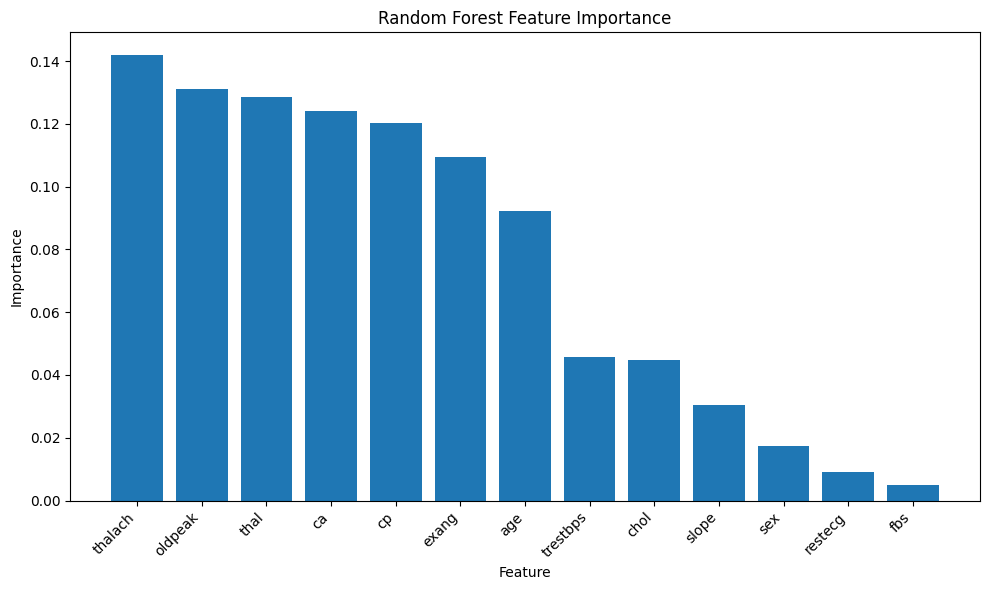

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

importances = rf.feature_importances_

imp_df = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

print(imp_df)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(imp_df["feature"], imp_df["importance"])
plt.xticks(rotation=45, ha="right")
plt.title("Random Forest Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, test_pred)

TN, FP, FN, TP = cm.ravel()

print("Confusion Matrix:")
print(cm)

print("\nExtracted values:")
print("TN (Healthy correctly identified):", TN)
print("FP (Healthy misclassified as sick):", FP)
print("FN (Sick misclassified as healthy):", FN)
print("TP (Sick correctly identified):", TP)

print("\nClassification Report:")
print(classification_report(y_test, test_pred, digits=4))


Confusion Matrix:
[[45  3]
 [11 31]]

Extracted values:
TN (Healthy correctly identified): 45
FP (Healthy misclassified as sick): 3
FN (Sick misclassified as healthy): 11
TP (Sick correctly identified): 31

Classification Report:
              precision    recall  f1-score   support

           0     0.8036    0.9375    0.8654        48
           1     0.9118    0.7381    0.8158        42

    accuracy                         0.8444        90
   macro avg     0.8577    0.8378    0.8406        90
weighted avg     0.8541    0.8444    0.8422        90



<div dir=rtl>
## در سیستم تشخیص بیماری قلبی، از دست دادن بیمار (FN) به‌مراتب خطرناک‌تر از تشخیص اشتباه سالم به‌عنوان بیمار (FP) است.
FP  شامل هزینه های درمان استرس و آزمایشات بیشتر می شود